## Cognitive Battery Introduction: Jax-3DP3

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import jax3dp3
from jax3dp3.viz import (
    save_depth_image,
    get_depth_image,
    multi_panel,
)
from jax3dp3.transforms_3d import transform_from_pos, depth_to_coords_in_camera
from jax3dp3.jax_rendering import (
    get_rectangular_prism_shape,
    render_planes_multiobject,
    batched_scorer_parallel_params,
)
import jax.numpy as jnp
import jax
from scipy.spatial.transform import Rotation as R
from jax3dp3.viz import make_gif_from_pil_images
from PIL import Image
from sklearn.cluster import KMeans, OPTICS, DBSCAN
import trimesh
from tqdm import tqdm

import cog_utils as utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


1. Initialize camera metadata and path to data:

In [2]:
scene = "gravity"
data_path = f"/home/khaledshehada/cog_jax3dp3_data/{scene}_data/videos/"
num_frames = len(os.listdir(os.path.join(data_path, "frames")))

In [3]:
width = 300
height = 300
fov = 90

fx, fy, cx, cy = utils.get_camera_intrinsics(width, height, fov)

fx_fy = jnp.array([fx, fy])
cx_cy = jnp.array([cx, cy])
near, far = 0.001, 50.0
K = jnp.array(
    [
        [fx_fy[0], 0.0, cx_cy[0]],
        [0.0, fx_fy[1], cx_cy[1]],
        [0.0, 0.0, 1.0],
    ]
)

jax3dp3.setup_renderer(height, width, fx, fy, cx, cy, near, far)

Increasing frame buffer size to (width, height, depth) = (320, 320, 2048)


2. Load ground-truth RGB images, depth, and segmentation data.


In [4]:
rgb_images, depth_images, seg_maps = [], [], []
rgb_images_pil = []
for i in range(num_frames):
    rgb_path = os.path.join(data_path, f"frames/frame_{i}.jpeg")
    if not os.path.isfile(rgb_path):
        rgb_path = rgb_path.replace("jpeg", "png")
    rgb_img = Image.open(rgb_path)
    rgb_images_pil.append(rgb_img)
    rgb_images.append(np.array(rgb_img))

    depth_path = os.path.join(data_path, f"depths/frame_{i}.npy")
    depth_npy = np.load(depth_path)
    depth_images.append(depth_npy)

    seg_map = np.load(os.path.join(data_path, f"segmented/frame_{i}.npy"))
    seg_maps.append(seg_map)

3. Mask the depth and segmentation images to only include the relevant part of the scene (i.e. crop to the box above table).

In [5]:
coord_images = []  # depth data in 2d view as images
seg_images = []  # segmentation data as images

for frame_idx in range(num_frames):
    coord_image, _ = depth_to_coords_in_camera(depth_images[frame_idx], K)
    segmentation_image = seg_maps[frame_idx].copy()
    mask = np.invert(
        # (coord_image[:, :, 0] < 2.0)
        # * (coord_image[:, :, 0] > -1)
        # * (coord_image[:, :, 1] < 0.463)
        # * (coord_image[:, :, 1] > -0.8)
        # * (coord_image[:, :, 2] < 3)
        # * (coord_image[:, :, 2] > 0.25)
        (coord_image[:, :, 0] < 1.1)
        * (coord_image[:, :, 0] > -1)
        * (coord_image[:, :, 1] < 0.565)
        * (coord_image[:, :, 1] > -1)
        * (coord_image[:, :, 2] > 1.2)
        * (coord_image[:, :, 2] < 1.35)
    )
    coord_image[mask, :] = 0.0
    segmentation_image[mask, :] = 0.0
    coord_images.append(coord_image)
    seg_images.append(segmentation_image)

coord_images = np.stack(coord_images)
seg_images = np.stack(seg_images)

In [6]:
# Load meshes
meshes = []
meshes_path = "/home/khaledshehada/cog_jax3dp3_data/gravity_data/meshes/"
for mesh_name in os.listdir(meshes_path):
    mesh_path = os.path.join(meshes_path, mesh_name)
    mesh = trimesh.load(mesh_path)
    jax3dp3.load_model(mesh)
    meshes.append(mesh_name.replace(".obj", ""))
    print(meshes[-1])

apple
tube_s_long
bowl
tube_s


4. Pick a starting frame and initialize the object shapes and poses from that frame

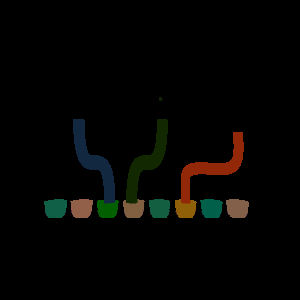

In [16]:
start_t = 36
seg_img = seg_images[start_t]
Image.fromarray(seg_img)

[0 0 0] 252201
[146  40   8] 6464
[18 40 64] 7596
[18 40  0] 91119
[16 96 72] 3856
[130  96  73] 3832
[146  96  72] 5063
[ 0 96 73] 87372
[18 96 65] 6132
[144  96   9] 3361
[ 2 96  1] 3344
[128  96  65] 3683
[16 32  9] 721
[73 68 32] 66
[145  68   8] 1280
[10 68 32] 63
[25 48 32] 80
[97 48 68] 77
[24 48 68] 76
[88 48 64] 1271
[96 48 36] 59
[32 48 68] 75
[33 48 64] 1270
[89 48 68] 75


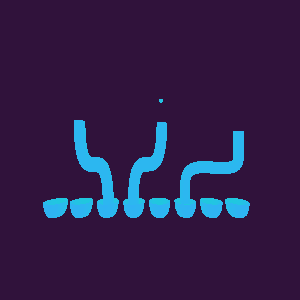

In [26]:
num_objects = 12
indices, poses = [], []
obj_ids = jnp.unique(seg_img.reshape(-1, 3), axis=0)
obj_ids = sorted(
    obj_ids,
    key = lambda x: jnp.all(seg_img == x, axis=-1).sum(),
    reverse = True
)
for obj_id in obj_ids[:num_objects + 1]:
    if jnp.all(obj_id == 0):
        # Background
        continue
    
    obj_mask = jnp.all(seg_img == obj_id, axis=-1)
    masked_depth = coord_images[start_t].copy()
    masked_depth[~obj_mask] = 0

    object_points = coord_images[start_t][obj_mask]
    maxs = np.max(object_points, axis=0)
    mins = np.min(object_points, axis=0)
    dims = maxs - mins
    obj_center = (maxs + mins) / 2
    obj_transform = transform_from_pos(obj_center)

    best = None
    k = np.inf
    for m in range(len(meshes)):
        obj_transforms = utils.get_object_transforms(meshes[m], obj_transform)
        for i, transform in enumerate(obj_transforms):
            rendered_image = jax3dp3.render_single_object(transform, m)
            keep_points = jnp.sum(
                jnp.logical_or(
                    ((masked_depth[:, :, 2] != 0.0) * (rendered_image[:, :, 2] == 0)),
                    ((masked_depth[:, :, 2] == 0.0) * (rendered_image[:, :, 2] != 0)),
                )
            ) / (rendered_image[:, :, 2] != 0.0).sum()
            if keep_points < k:
                k = keep_points
                best = (m, transform)
    if best:
        indices.append(best[0])
        poses.append(best[1])

rendered_image = jax3dp3.render_multiobject(jnp.array(poses), indices)
get_depth_image(rendered_image[:, :, 2], max=5)

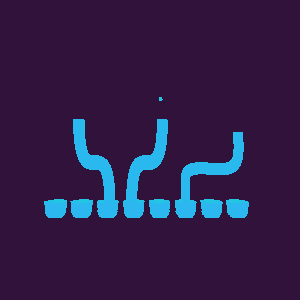

In [18]:
jax3dp3.viz.get_depth_image(coord_images[start_t][:, :, 2], max=5)

In [ ]:
coord_images[start_t].shape

In [ ]:
meshes

In [ ]:
obj_ids = set()
shape_planes, shape_dims, init_poses = [], [], []
for obj_id in jnp.unique(seg_img):
    obj_mask = jnp.all(seg_img == obj_id, axis=-1)
    if obj_id == 0:
        continue
    # if scene == "shape" and np.sum(obj_mask) < 100:  # Only for shape, [TODO] delete or automate later
    #     continue
    if jnp.all(obj_id == 0) or seg_img[obj_mask].shape[0] < 15:
        continue

    object_points = coord_images[start_t][obj_mask]
    maxs = np.max(object_points, axis=0)
    mins = np.min(object_points, axis=0)
    dims = maxs - mins
    center_of_box = (maxs + mins) / 2

    init_pose = transform_from_pos(center_of_box)
    init_poses.append(init_pose)

    shape, dim = get_rectangular_prism_shape(dims)
    shape_planes.append(shape)
    shape_dims.append(dim)
    obj_ids.add(obj_id.item())
shape_planes = jnp.stack(shape_planes)
shape_dims = jnp.stack(shape_dims)
init_poses = jnp.stack(init_poses)

5. Save the reconstructed depths to check that they align with the actual depths.

In [ ]:
def render_planes_multiobject_lambda(poses):
    return render_planes_multiobject(
        poses, shape_planes, shape_dims, height, width, fx, fy, cx, cy
    )


def render_planes_multiobject_multi_lambda(poses, planes, dims):
    return render_planes_multiobject(poses, planes, dims, height, width, fx, fy, cx, cy)


render_planes_multiobject_jit = jax.jit(render_planes_multiobject_lambda)
render_planes_multiobject_multi_jit = jax.jit(render_planes_multiobject_multi_lambda)

reconstruction_image = render_planes_multiobject_jit(init_poses)
get_depth_image(reconstruction_image[:, :, 2], max=5.0)

6. Define the liklihood methods and the proposal enumerations.

In [ ]:
# Liklihood parameters
r = radius = 0.05
outlier_prob = 0.01
outlier_volume = 1

# Enumeration parameters
n = 5  # number of enumerated proposals on each dimension (x, y, z).
d = 0.1  # the minimum and maximum position delta on each dimension (x, y, z).

# Liklihood methods
def likelihood(x, params):
    obs = params[0]
    rendered_image = render_planes_multiobject(
        x, shape_planes, shape_dims, height, width, fx, fy, cx, cy
    )
    weight = jax3dp3.threedp3_likelihood(
        obs, rendered_image, r, outlier_prob, outlier_volume
    )
    return weight


likelihood_parallel = jax.vmap(likelihood, in_axes=(0, None))
batched_scorer_parallel_jit = jax.jit(
    lambda poses, image: batched_scorer_parallel_params(
        likelihood_parallel, n, poses, (image,)
    )
)

# Enumerating proposals
enumerations = jax3dp3.make_translation_grid_enumeration(-d, -d, -d, d, d, d, n, n, n)

7. For each frame, enumerate the positions of new object poses (currently translation only), and for each object pick the pose that maximizes the 3DP3 liklihood under a uniform prior.

In [ ]:
pose_estimates = init_poses.copy()
t = start_t
gt_image = jnp.array(coord_images[t])
i = 0
enumerations_full = jnp.tile(
    jnp.eye(4)[None, :, :],
    (enumerations.shape[0], pose_estimates.shape[0], 1, 1),
)
enumerations_full = enumerations_full.at[:, i, :, :].set(enumerations)
proposals = jnp.einsum("bij,abjk->abik", pose_estimates, enumerations_full)

weights = batched_scorer_parallel_jit(proposals, gt_image)
pose_estimates = proposals[weights.argmax()]

In [ ]:
# # New objects
# gt_image = jnp.array(coord_images[t])

# depth_full = render_planes_multiobject_jit(pose_estimates)[:,:,2]
# depth_difference = gt_image.at[jnp.where(depth_full != 0)].set(0)

# depth_difference = depth_difference.reshape(-1, 3)
# clustering = KMeans().fit(gt_image.reshape(-1, 3))
# labels = clustering.labels_.reshape(300, 300)

# for label in range(labels.max()):
#     gt_image = jnp.array(coord_images[t]).at[labels != label].set(0)
#     save_depth_image(gt_image[:,:,2], f"clustering/{label}.png", max=5)

In [ ]:
num_steps = num_frames - start_t
num_steps = 2
occlusion_threshold = 10
inferred_poses = []
pose_estimates = init_poses.copy()
for t in tqdm(range(start_t, start_t + num_steps)):
    gt_image = jnp.array(coord_images[t])

    # New objects
    n_objects = pose_estimates.shape[0]
    for i in range(n_objects):
        # Occlusion detection: render depth with and without each object. If no difference, don't move object.
        depth_with_object = render_planes_multiobject_jit(pose_estimates)
        idxs = jnp.arange(n_objects) != i
        depth_without_object = render_planes_multiobject_multi_jit(
            pose_estimates[idxs],
            shape_planes[idxs],
            shape_dims[idxs],
        )

        if (
            jnp.sum(depth_with_object[:, :, 2] != depth_without_object[:, :, 2])
            < occlusion_threshold
        ):
            continue

        enumerations_full = jnp.tile(
            jnp.eye(4)[None, :, :],
            (enumerations.shape[0], pose_estimates.shape[0], 1, 1),
        )
        enumerations_full = enumerations_full.at[:, i, :, :].set(enumerations)
        proposals = jnp.einsum("bij,abjk->abik", pose_estimates, enumerations_full)

        weights = batched_scorer_parallel_jit(proposals, gt_image)
        pose_estimates = proposals[weights.argmax()]
    inferred_poses.append(pose_estimates.copy())

8. Get the reconstructed poses for each frame and save them as a gif file with the gt data

In [ ]:
all_images = []
for t in range(start_t, start_t + num_steps):
    rgb_viz = Image.fromarray(rgb_images[t].astype(np.int8), mode="RGB")
    gt_depth_1 = get_depth_image(coord_images[t][:, :, 2], max=5.0)
    depth = render_planes_multiobject_jit(inferred_poses[t - start_t])
    depth = get_depth_image(depth[:, :, 2], max=5.0)
    all_images.append(
        multi_panel(
            [rgb_viz, gt_depth_1, depth],
            [f"\nRGB Image", f"   Frame: {t}\nActual Depth", "\nReconstructed Depth"],
            middle_width=10,
            label_fontsize=20,
        )
    )
out_path = f"{scene}_out.gif"
make_gif_from_pil_images(all_images, out_path)
print("Saved output to:", out_path)